## Distance to nearest linestring from a point

These are some simple explorations on a constructed example

There are two broad methods here

1.  Calculate distance from point to nearest point along a bikepath (using shapely's `project`)

2. (less promising) convert linestrings to points and then use nearest neighbors.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, mapping
import geopandas as gpd
import pandas as pd

#### Make up some paths

In [2]:
path1 = LineString([
    Point(0, 0),
    Point(0, 1),
    Point(1, 1),
    Point(1, 2),
    Point(3, 3),
    Point(5, 6),
])

path2 = LineString([
    Point(5, 3),
    Point(5, 5),
    Point(9, 5),
    Point(10, 7),
    Point(11, 8),
    Point(12, 12),
])

path3 = LineString([
    Point(9, 10),
    Point(10, 14),
    Point(11, 12),
    Point(12, 15),
])

In [3]:
gdf = gpd.GeoDataFrame([path1, path2, path3], columns=['geometry'])

In [4]:
gdf['pathname'] = ['path1', 'path2', 'path3']

In [5]:
gdf

,geometry,pathname
0,"LINESTRING (0 0, 0 1, 1 1, 1 2, 3 3, 5 6)",path1
1,"LINESTRING (5 3, 5 5, 9 5, 10 7, 11 8, 12 12)",path2
2,"LINESTRING (9 10, 10 14, 11 12, 12 15)",path3


Here are the made up paths:

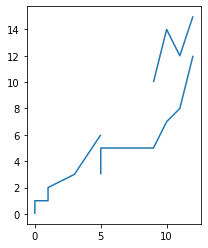

In [6]:
gdf.plot();

In [7]:
We can calculate a buffer around any 

SyntaxError: invalid syntax (<ipython-input-7-9a622583f87c>, line 1)

In [ ]:
r  = 5  #buffer radius
B = p.buffer(r)
B

Plot things on matplotlib to visualize what's going on.


In [ ]:
x1,y1 = path1.xy
x2,y2 = path2.xy
x3,y3 = path3.xy
xB,yB = B.exterior.xy

plt.plot(xB,yB)
plt.plot(x1,y1)
plt.plot(x2,y2)
plt.plot(x3,y3)
plt.scatter(p.x,p.y)
ax = plt.gca()
ax.set_aspect("equal")


We can get just the linestrings in the buffer returned as a new dataframe

In [ ]:
gdf.geometry.intersection(p.buffer(4))

In [ ]:
plt.plot(xB,yB)
plt.scatter(p.x,p.y)
ax=plt.gca()
gdf.geometry.intersection(p.buffer(r)).plot(ax=ax);

Simple loop to find distances from point to lines in this buffer

In [ ]:
for line in gdf.geometry.intersection(p.buffer(r)):
    if not line.is_empty:
        print(line.project(p))
        

This is obviously incomplete (we need code to loop through all the bikepaths) and then return the nearest distance but it would probably use these building blocks.

## A less promising method

Ignore what follows.  I abandoned this method after realizing that a bikepath is not just the vertices that define the line (so previous method better).  But I learned some tricks in my explorations, so I've kept the code in case they ever come in handy.

### From linestring back to points

[This stackexchange answer](https://gis.stackexchange.com/questions/238533/how-do-i-extract-points-from-a-linestring-or-polygon-data-frame-and-make-a-dicti) shows how to convert from a linestring into a list of points lists.

In [ ]:
def linestring_to_points(feature, line):
    return np.array(line.coords)

gdf['points'] = gdf.apply(lambda line: linestring_to_points(line['pathname'],line['geometry']),axis=1)

In [ ]:
gdf.geometry.intersection(p.buffer(4)).plot();

In [ ]:
gdf.plot();

After some further searching I found that I can use numpy concatenate to get all the points into a stacked numpy array.

In [ ]:
np.concatenate(gdf.points)

We can turn these back into shapely points

In [ ]:
gpd.GeoSeries(map(Point,np.concatenate(gdf.points)))

We will want to create a new dataframe with these points but we need to label them correctly with their corresponding bike path name.  The numpy `repeat` function allows us to repeat the line name the correct number of times. 

In [ ]:
np.repeat(gdf.pathname.values, gdf.points.apply(len))

So finally, let's create a dataframe that lists points and associated bike paths.

In [ ]:
pathpts = pd.DataFrame({ 'path': np.repeat(gdf.pathname.values, gdf.points.apply(len)),
                      'pt': gpd.GeoSeries(map(Point,np.concatenate(gdf.points)))
                   }  )
pathpts